In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt

# Hands on Exercise for Time Series Forecasting of Telemetry Data & Equipment Errors
Please review the Kaggle dataset provided below to complete the exercise. We are seeking to evaluate your approach to the following activities:
1) Access & prepare data
2) Provisioning and configuration of python instance
3) Forecast values for the 100 machines / equipment and identify potential errors 24 hours in advance of the predicted error (24 hour forecast). Note we expect candidates to lead us through their EDA in detail as to how / why they constructed their model as they did. 
4) Walk us through the results in a 90 min meeting and deliver code for our review

Here you'll find the data that should be used on the ML exercise. The data covers some machine telemetry time series and failures. The objective is to **predict when a machine will fall into failures** to **build a proactive maintenance schedule over a selected time window**. Additionally, we would like to understand **what are the key features that are indicative of an upcoming failure.** Typically we just review the Jupyter notebook of the candidate. 

Please let us know if you have any questions. 


## Exploratory Data Analysis

## Telemetry
Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

In [2]:
telemetry = pd.read_csv('./archive/PdM_telemetry.csv')
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [3]:
telemetry['datetime'].min(), telemetry['datetime'].max()

('2015-01-01 06:00:00', '2016-01-01 06:00:00')

Telemetry data only present for 2015.

In [4]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime']) # convert datetime column to datetime type

<Axes: xlabel='datetime', ylabel='vibration'>

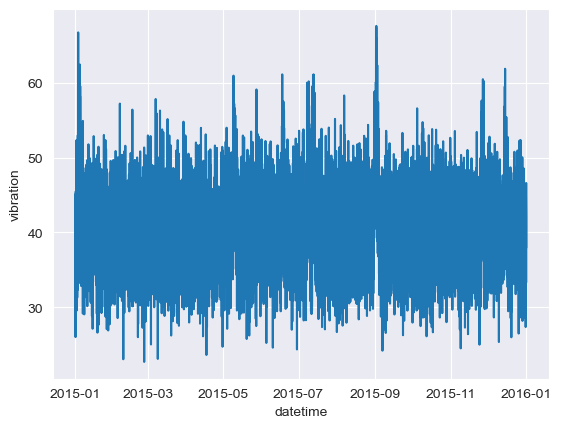

In [5]:
sns.lineplot(data = telemetry.query('machineID == 1'), x = 'datetime', y = 'vibration')

Vibration and other sensor data looks like noise, but it may still contain useful information. There seem to be high and low spikes over time that could potentially be related to machine failure. 

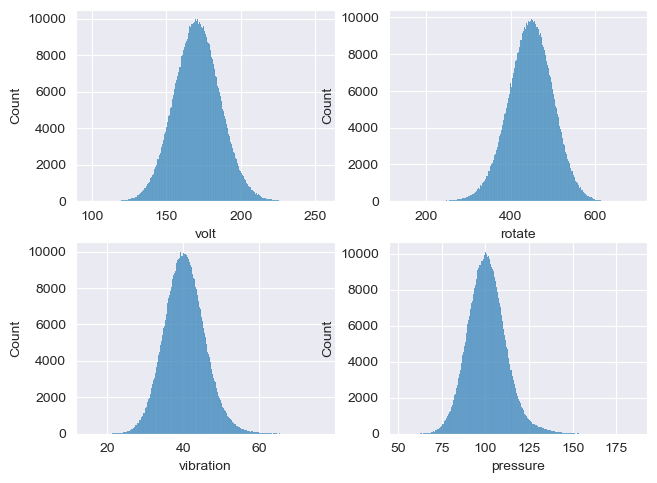

In [6]:
fig, axes = plt.subplots(2, 2)
plt.tight_layout()
params = ["volt", "rotate", "vibration", "pressure"]
indices = [(i, j) for i in range(2) for j in range(2)]
for (i, j), col in zip(indices, params):
    sns.histplot(data = telemetry, x = col, ax = axes[i][j])

Sensor data looks approximately Gaussian (maybe slightly assymmetric). Since it looks approximately Gaussian, we could potentially use mean and standard deviation of sensor data as features. 

### Telemetry has autocorrelation in 24 hour window
If telemetry data turns out to be a relevant feature in predicting failures, we can feature engineer lags in this data to predict what it will be in 24 hours. 

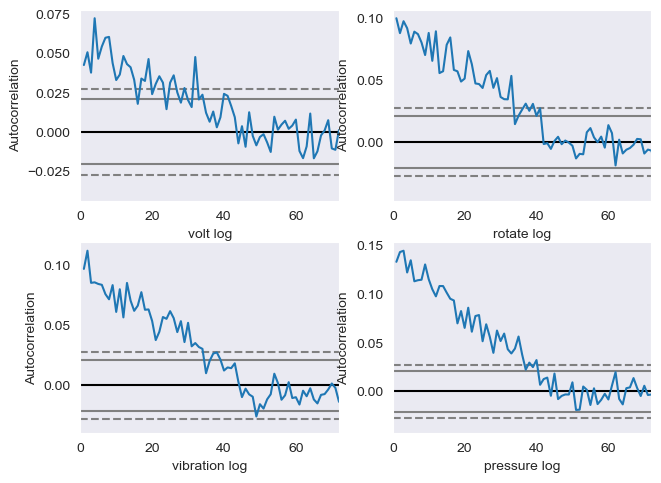

In [7]:

fig, axes = plt.subplots(2, 2)
plt.tight_layout()
params = ["volt", "rotate", "vibration", "pressure"]
indices = [(i, j) for i in range(2) for j in range(2)]
for (i, j), col in zip(indices, params):
    pd.plotting.autocorrelation_plot(telemetry.query('machineID == 10')[col], ax = axes[i][j])
    axes[i][j].set_xlim(0, 24 * 3)
    #axes[i][j].set_title(col)
    axes[i][j].set_xlabel(f'{col} log')
    # sns.histplot(data = telemetry, x = col, ax = axes[i][j])


## Errors
Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [8]:
errors = pd.read_csv('./archive/PdM_errors.csv')
errors['datetime'] = pd.to_datetime(errors['datetime'])
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [9]:
errors.describe()

,machineID
count,3919.000000
mean,51.044654
std,28.954988
min,1.000000
25%,25.000000
50%,51.000000
75%,77.000000
max,100.000000


In [10]:
errors.dtypes

datetime     datetime64[ns]
machineID             int64
errorID              object
dtype: object

In [11]:
errors['datetime'] = pd.to_datetime(errors['datetime'])
errors.dtypes

datetime     datetime64[ns]
machineID             int64
errorID              object
dtype: object

In [12]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


### Machines usually see `error1` and `error2` types of errors

<Axes: xlabel='errorID', ylabel='count'>

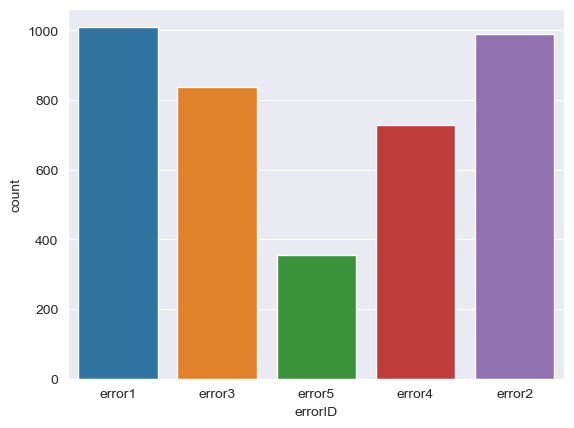

In [13]:
sns.countplot(data = errors, x = 'errorID')

<Axes: xlabel='day', ylabel='errorID'>

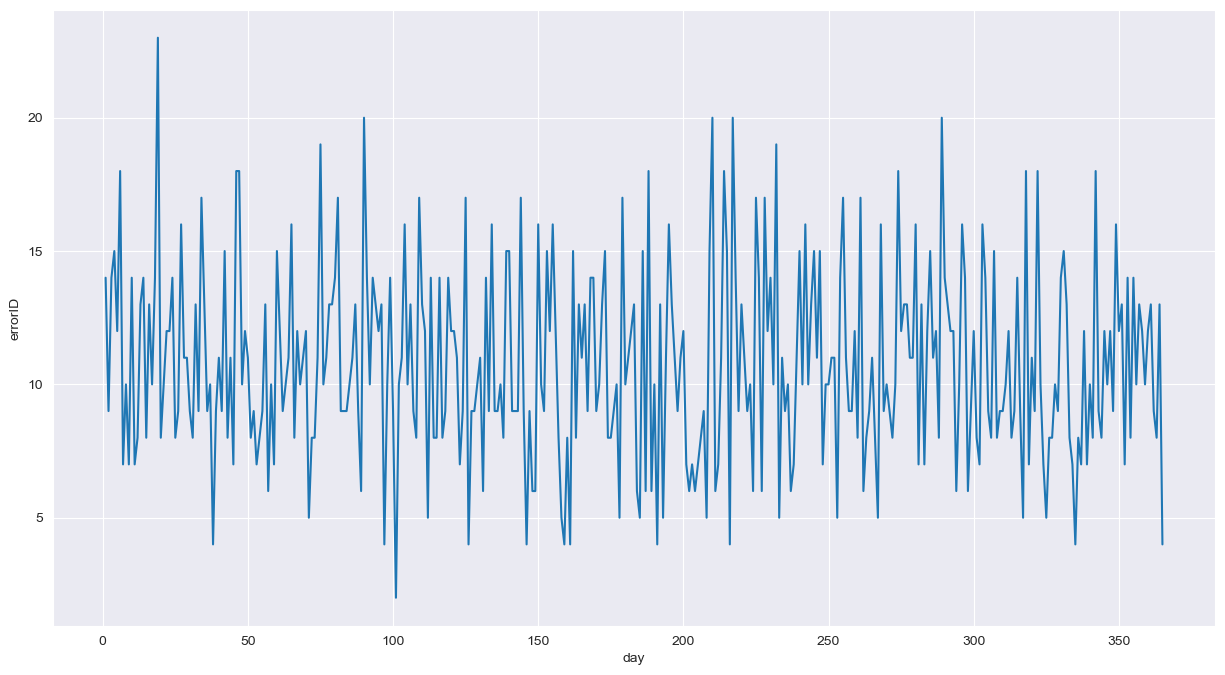

In [14]:
plt.figure(figsize=(15, 8))
errors['day'] = errors['datetime'].apply(lambda r: r.dayofyear)
errors_by_day = errors.groupby('day').count()

sns.lineplot(data = errors_by_day, x = 'day', y = 'errorID')

The number of errors does not seem to correlate with the day of the year. Seasonality may not play a large role in creating errors. 

## Maintenance
Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [15]:
maintenance = pd.read_csv('./archive/PdM_maint.csv')
maintenance['datetime'] = pd.to_datetime(maintenance['datetime'])

maintenance.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


### Maintenance is done on 4 different components (approximately same frequency for each)

<Axes: xlabel='comp', ylabel='count'>

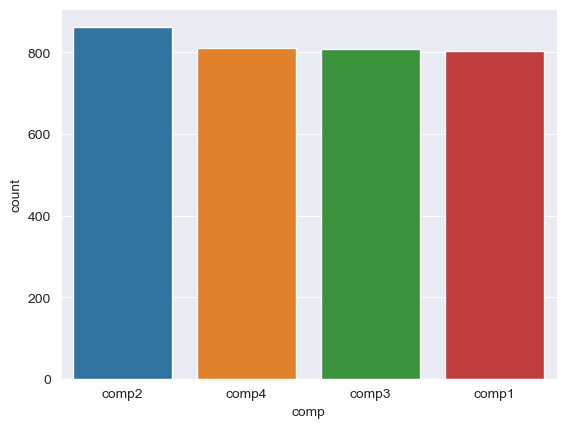

In [16]:
sns.countplot(data = maintenance, x = 'comp')

In [17]:
maint_by_id = maintenance.groupby(['machineID']).count()
maint_by_id

,datetime,comp
machineID,,
1,37,37
2,32,32
3,37,37
4,33,33
5,35,35
...,...,...
96,33,33
97,34,34
98,37,37


### No particular machine seems to be maintained more frequently than the others
It seems `machineID` is not strongly correlated with being maintained. 

<Axes: xlabel='machineID', ylabel='comp'>

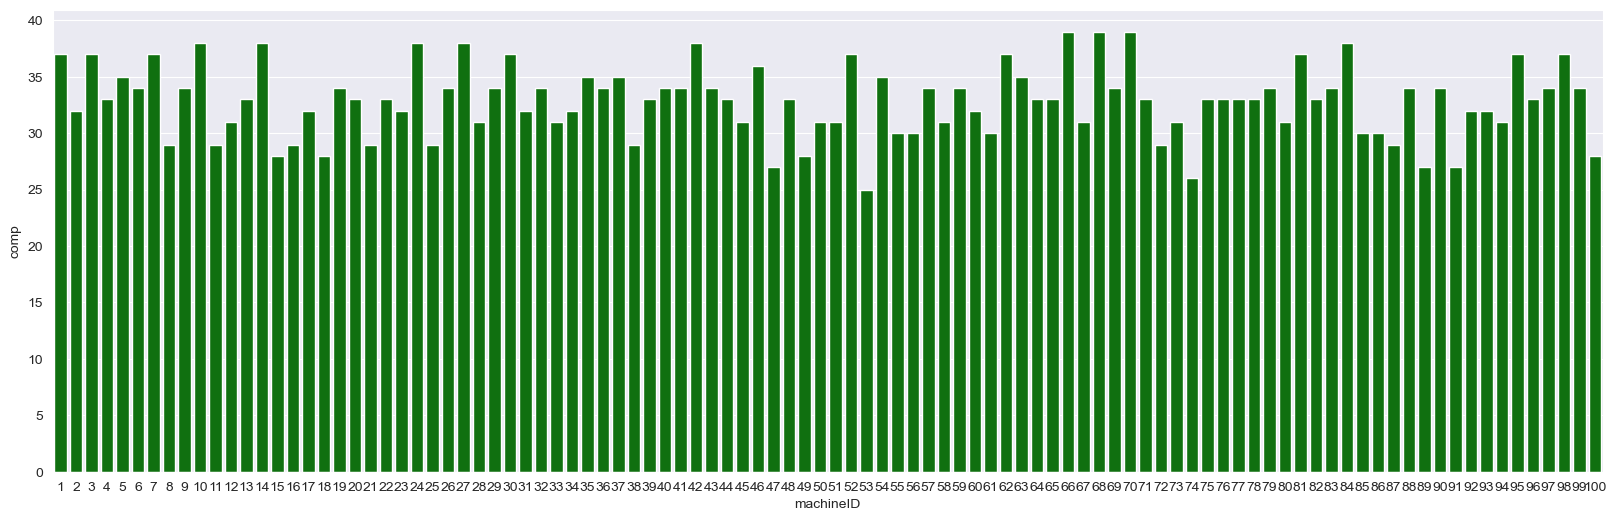

In [18]:
plt.figure(figsize=(20, 6))
sns.barplot(y = maint_by_id['comp'], x = maint_by_id.index, color='green')

<Axes: xlabel='datetime', ylabel='comp'>

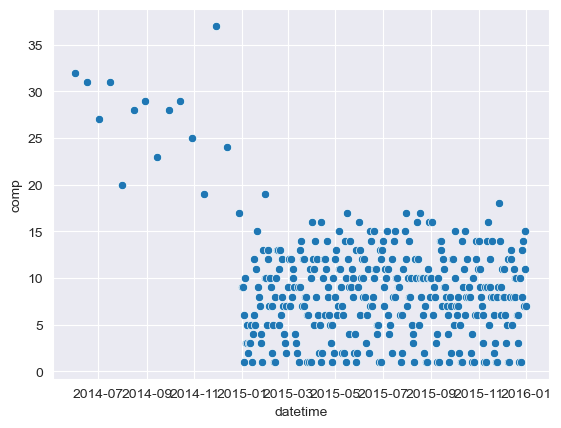

In [19]:
maintenance['day'] = maintenance['datetime'].apply(lambda x: x.dayofyear)
maint_by_day = maintenance.groupby(['datetime']).count()

sns.scatterplot(data = maint_by_day, x = 'datetime', y = 'comp')

Maintenance records go back to 2014, but are more common in 2015 onwards. Since we'd like to use telemetry data, we'll restrict our analysis to 2015 maintenance records. 

## Machines
Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines

In [20]:
machines = pd.read_csv('archive/PdM_machines.csv')
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [21]:
machines.describe()

,machineID,age
count,100.000000,100.000000
mean,50.500000,11.330000
std,29.011492,5.856974
min,1.000000,0.000000
25%,25.750000,6.750000
50%,50.500000,12.000000
75%,75.250000,16.000000
max,100.000000,20.000000


Machine ages range from new to 20 years old. Older machines could result in more failures, so we'll include age as a numerical feature. 

In [22]:
machines.dtypes

machineID     int64
model        object
age           int64
dtype: object

### No glaring age distribution imbalances
We'll keep the model number as a categorical feature in case it is correlated with machine failure. 

<Axes: xlabel='age', ylabel='Count'>

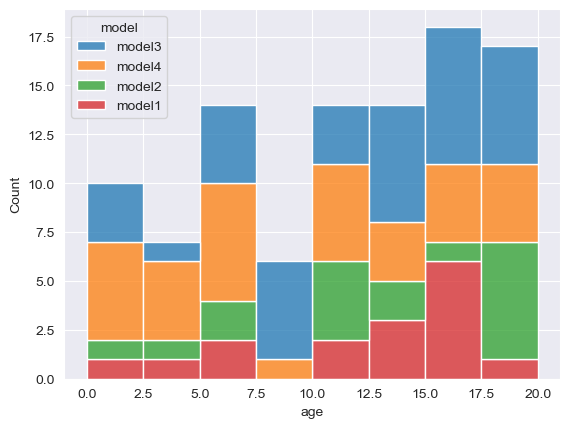

In [23]:
sns.histplot(data = machines, x = 'age', multiple='stack', hue = 'model')

### Are older machines more likely to produce errors?

In [24]:
errors.groupby(['machineID']).count()

,datetime,errorID,day
machineID,,,
1,35,35,35
2,28,28,28
3,39,39,39
4,31,31,31
5,38,38,38
...,...,...,...
96,39,39,39
97,45,45,45
98,45,45,45


In [25]:
machines.set_index('machineID')

,model,age
machineID,,
1,model3,18
2,model4,7
3,model3,8
4,model3,7
5,model3,2
...,...,...
96,model2,10
97,model2,14
98,model2,20


In [26]:
age_errors = machines.set_index('machineID').join(errors.groupby(['machineID']).count())
age_errors

,model,age,datetime,errorID,day
machineID,,,,,
1,model3,18,35,35,35
2,model4,7,28,28,28
3,model3,8,39,39,39
4,model3,7,31,31,31
5,model3,2,38,38,38
...,...,...,...,...,...
96,model2,10,39,39,39
97,model2,14,45,45,45
98,model2,20,45,45,45


Text(0, 0.5, 'Total Errors')

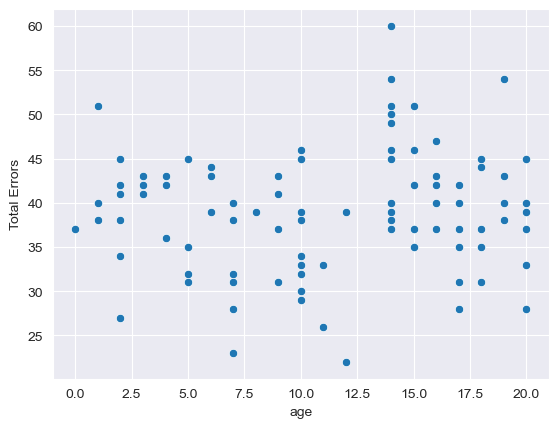

In [27]:
sns.scatterplot(data = age_errors, x = 'age', y = 'errorID')
plt.ylabel('Total Errors')

Age doesn't seem to be correlated with machine errors. 

## Failures

In [28]:
failures = pd.read_csv('archive/PdM_failures.csv')
failures['datetime'] = pd.to_datetime(failures['datetime'])

In [29]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


### Most failures are due to component `comp2`

<Axes: xlabel='failure', ylabel='Count'>

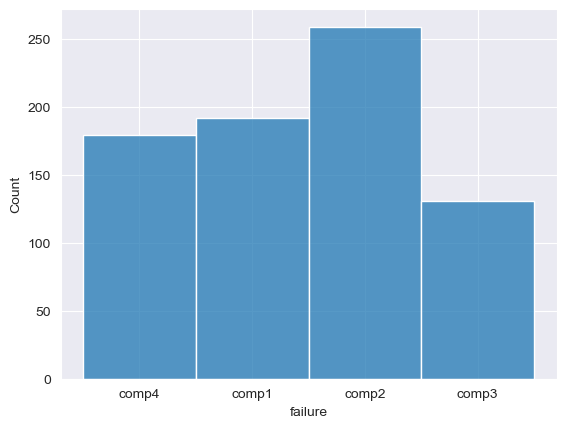

In [30]:
sns.histplot(data = failures, x = 'failure')

In [31]:
failures_by_age = machines.set_index('machineID').join(failures.groupby(['machineID']).count())

### Slight correlation between age and number of failures

<Axes: xlabel='age', ylabel='failure'>

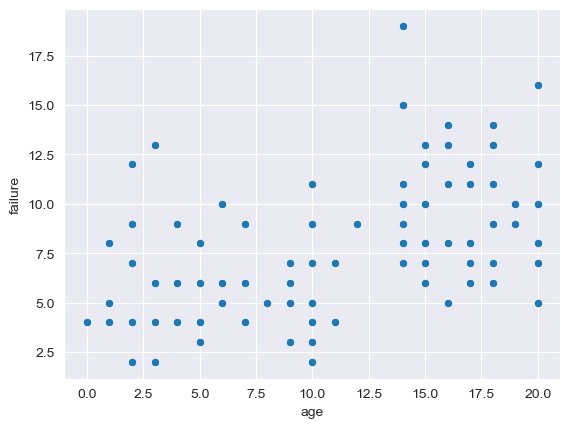

In [32]:
sns.scatterplot(data = failures_by_age, x = 'age', y = 'failure')

In [33]:
failures_by_age.corr()['age']['failure']

0.4764585995007374

Age has some correlation with failure. We'll include it as a feature moving forward.